**Dividing the csv file**

In [1]:
!pip install iterative-stratification

In [2]:
import numpy as np # linear algebra
import pandas as pd 

In [3]:
df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
df = df.fillna('Unknown')

In [4]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

fold = 0
for train_index, test_index in mskf.split(df, df.iloc[:,1:]):
    df.loc[test_index, 'fold'] = fold
    fold += 1

In [5]:
df['fold'] = df['fold'].astype(int)

In [6]:
df[['study_id', 'fold']].to_csv('5folds.csv', index=False)

**Creating Annotations and splitting the dataset**

In [7]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<00:52, 2.95kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<01:15, 6.77kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<01:04, 7.59kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<01:35, 9.68kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<05:25, 18.9kB/s]


In [8]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [9]:
FOLDS = [0,1,2,3,4]
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

In [10]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [11]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [12]:
fold_df = pd.read_csv('/kaggle/working/5folds.csv')

In [13]:
# get_level('spinal_canal_stenosis_l1_l2_normal/mild')
# # Output: 'L1/L2'
# get_condition('spinal_canal_stenosis_l1_l2_normal/mild')
# # Output: 'Spinal Canal Stenosis'

In [14]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

In [15]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [16]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [17]:
label_df.head()

,study_id,condition,level,label,fold
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,0
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,0
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,0
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,0
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,0


In [18]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [19]:
#used to retrive rows from label_df
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [20]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)  #read dcm file
    image = dicom_data.pixel_array         
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255  #normalize pixel values
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [34]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [35]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0) 
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
8160,723551942,Spinal Canal Stenosis,L2/L3,Normal/Mild,1,3780389705,9,242.656051,218.700637,Sagittal T2/STIR
8161,723551942,Spinal Canal Stenosis,L3/L4,Severe,1,3780389705,9,247.547771,276.585987,Sagittal T2/STIR
8162,723551942,Spinal Canal Stenosis,L4/L5,Normal/Mild,1,3780389705,9,265.484076,327.949045,Sagittal T2/STIR
8163,723551942,Spinal Canal Stenosis,L5/S1,Normal/Mild,1,3780389705,9,279.343949,372.789809,Sagittal T2/STIR


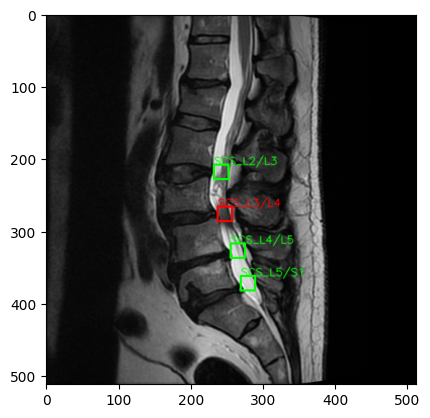

In [36]:
plt.imshow(img)
plt.show()

In [24]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [25]:
filtered_df.to_csv('filtered_data.csv', index=False)


In [26]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [27]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

In [28]:
def gen_yolo_format(ann_df, phase='train'):
    for name, group in tqdm(ann_df.groupby(['study_id', 'series_id', 'instance_number'])):
        study_id, series_id, instance_num = name[0], name[1], name[2]
        path = f'{IMG_DIR}/{study_id}/{series_id}/{instance_num}.dcm'
        img = read_dcm(path)
        H, W = img.shape[:2]

        img_dir = os.path.join(OUT_DIR, 'images', phase)
        os.makedirs(img_dir, exist_ok=True)
        img_path = os.path.join(img_dir, f'{study_id}_{series_id}_{instance_num}.jpg')
        cv2.imwrite(img_path, img)

        ann_dir = os.path.join(OUT_DIR, 'labels', phase)
        os.makedirs(ann_dir, exist_ok=True)
        ann_path = os.path.join(ann_dir, f'{study_id}_{series_id}_{instance_num}.txt')
        with open(ann_path, 'w') as f:
            for i, row in group.iterrows():
                cond = row['condition']
                level = row['level']
                severity = row['label']
                class_label = f"{cond.lower().replace(' ', '_')}_{level.lower().replace('/', '_')}_{severity.lower()}"
                class_id = label2id[class_label]
                x_center = row['x'] / W
                y_center = row['y'] / H
                width = W / OD_INPUT_SIZE * STD_BOX_SIZE / W
                height = H /  OD_INPUT_SIZE * STD_BOX_SIZE / H
                f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')


In [29]:
for FOLD in FOLDS:
    OUT_DIR = f'data_fold{FOLD}'
    os.makedirs(OUT_DIR, exist_ok=True)
    
    train_df = filtered_df[filtered_df.fold != FOLD]
    val_df = filtered_df[filtered_df.fold == FOLD]
    
    gen_yolo_format(train_df, phase='train')
    gen_yolo_format(val_df, phase='val')

  0%|          | 0/2013 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/2032 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/2016 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [30]:
ls data_fold0

images/  labels/


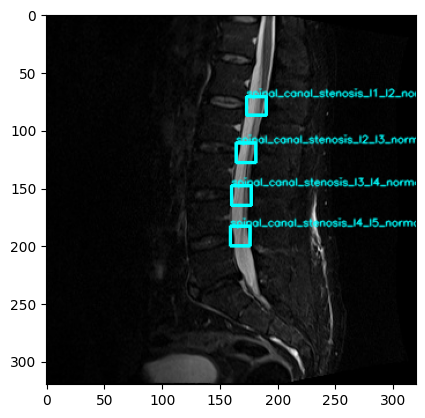

In [31]:
# testing generated annotations

_IM_DIR = f'{OUT_DIR}/images/train'
_ANN_DIR = f'{OUT_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [32]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [33]:
!zip -r -q data_fold0.zip data_fold0